## Load Dataset

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import math

In [7]:
# 1. 전처리 미리 정의
IMG_SIZE = (64, 64)
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(), # 1) [0.0, 1.0] 실수 범위로 압축, 2) (H, W, C) -> (C, H, W)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 각각의 RGB 채널 평균 0.5, 표준편차 0.5로 Norm
])

# 2. Load train/validation/test datasets
train_set = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_set = torchvision.datasets.Flowers102(root='/data', split='val', download=True, transform=transform)
test_set = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

# 3. 데이터셋 3종류 하나로 합치기(validation, test 불필요)
dataset = ConcatDataset([train_set, val_set, test_set])

# 4. 필요없는 변수 삭제 -> 메모리 절약
del train_set, val_set, test_set

# 5. dataloader
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 섞기
    num_workers=2, # 데이터 로드 병렬 (CPU 프로세스 2개 사용)
    drop_last=True # 자투리 버리기
)

In [27]:
# shape 확인
iterForShapeCheck = iter(dataloader)
oneBatchTensorForShapeCheck = next(iterForShapeCheck)[0]
print(f"Shape of One Batch: {oneBatchTensorForShapeCheck.shape}")

Shape of One Batch: torch.Size([64, 3, 64, 64])


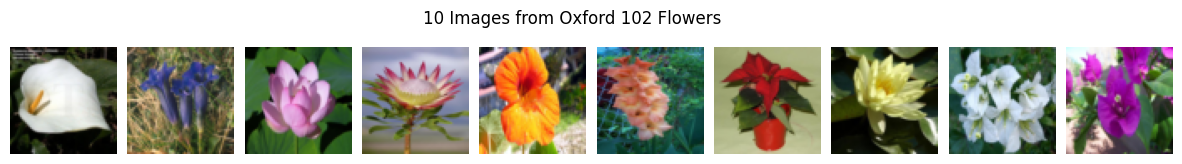

In [21]:
# 10개만 시각화해서 확인
## 1) batch 하나 준비
dataIterator = iter(dataloader) # dataloader은 iterable 하지만 iterator는 아님 -> iterator로 만들어주기
images, labels = next(dataIterator) # images, labels에 batch 하나가 담김

## 2) 도화지 정의
fig, axes = plt.subplots(1, 10, figsize=(15, 3)) # fig: 전체 도화지, axes: 각각의 칸(numpy array)
plt.subplots_adjust(wspace=0.1) # 이미지 사이 간격

## 3) 그림 그리기
for i in range(10):
  img = images[i]
  img = (img * 0.5) + 0.5 # Normalize 했던거 원래대로 복구
  img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
  axes[i].imshow(img.cpu().numpy()) # numpy(): Tensor -> Numpy Array
  axes[i].axis('off') # 눈금제거

plt.suptitle("10 Images from Oxford 102 Flowers", y=0.8)
plt.show()

## Diffusion Schedule (Forward Process)

In [32]:
# 3가지 diffusion schedules - Linear/Cosine/Offset Cosine
class DiffusionSchedules:
  def __init__(self, T=1000):
    self.T = T
    self.times = torch.linspace(0, 1, T) # [0.000, 0.001, 0.002, ... 0.999, 1.000]

  ## 1) Linear Diffusion Schedules
  ### t 지나면서 beta가 linear 하게 커짐
  def linear_diffusion_schedule(self):
    ## beta 범위 설정
    min_beta = 0.0001
    max_beta = 0.02

    # betas, alphas, alpha_bars
    betas = min_beta + self.times * (max_beta - min_beta)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0) # coumprod: 누적 곱셈 [2, 3, 5] -> [2, 6, 30]

    # noise, blur rates(tensor)
    noise_rates = torch.sqrt(1 - alpha_bars)
    blur_rates = torch.sqrt(alpha_bars)

    return blur_rates, noise_rates # 앞에 곱하는걸 앞에 썼음.


  ## 2) Cosine Diffusion Schedules
  ### sin^2 + cos^2 = 1 이용한 schedule
  def cosine_diffusion_schedule(self):
    blur_rates = torch.cos(self.times * math.pi / 2)
    noise_rates = torch.sin(self.times * math.pi / 2)

    return blur_rates, noise_rates


  ## 3) Offset Cosine Schedules
  ### 너무 어둡거나 밝은 이미지 생성 방지
  def offset_diffusion_schedule(self):
    min_blur_rate = 0.02
    max_blur_rate = 0.95

    # min, max의 cos 각도
    start_angle = torch.acos(torch.tensor(max_blur_rate))
    end_angle = torch.acos(torch.tensor(min_blur_rate))

    # 각도를 linear하게 세팅해서 sin, cos 사용
    diffusion_angles = start_angle + self.times * (end_angle - start_angle)
    blur_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return blur_rates, noise_rates

### Schedules Visualizations

In [34]:
# Schedule별 blur_rates, noise_rates 시각화
schedules = DiffusionSchedules(T=1000) # Schdule들 모아놓은 class 호출
linear_blurs, linear_noises = schedules.linear_diffusion_schedule()
cosine_blurs, cosine_noises = schedules.cosine_diffusion_schedule()
offset_blurs, offset_noises = schedules.offset_diffusion_schedule()
diffusion_times = schedules.times

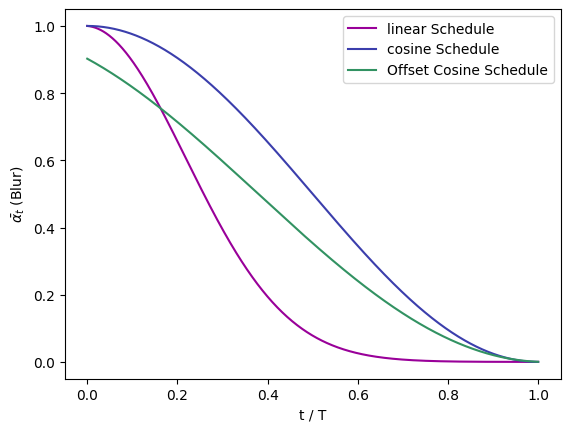

In [67]:
#1. blurs: alpha_t bar
plt.plot(diffusion_times, linear_blurs**2, color="#990099", label="linear Schedule")
plt.plot(diffusion_times, cosine_blurs**2, color="#3b3eac", label="cosine Schedule")
plt.plot(diffusion_times, offset_blurs**2, color="#329262", label="Offset Cosine Schedule")

plt.xlabel("t / T")
plt.ylabel(r"$\bar{\alpha_t}$ (Blur)")
plt.legend()
plt.show()

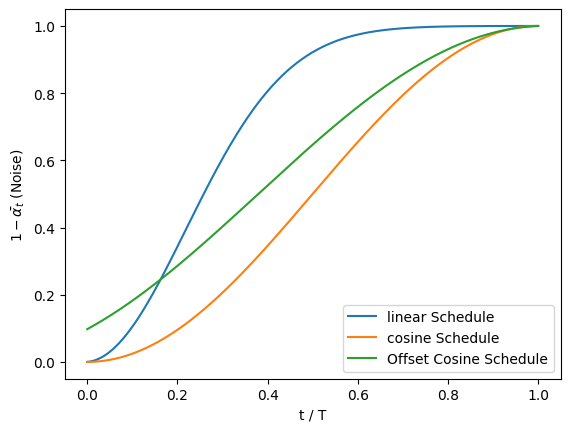

In [39]:
#2. noises: 1 - alpha_t bar
plt.plot(diffusion_times, linear_noises**2, label="linear Schedule")
plt.plot(diffusion_times, cosine_noises**2, label="cosine Schedule")
plt.plot(diffusion_times, offset_noises**2, label="Offset Cosine Schedule")

plt.xlabel("t / T")
plt.ylabel(r"$1-\bar{\alpha_t}$ (Noise)")
plt.legend()
plt.show()